In [1]:
import h5py
import glob
import numpy as np
import pandas as pd
import hdf5plugin
pd.set_option('display.max_rows', 100)  # Adjust the number of rows to show
pd.set_option('display.max_columns', 50)  # Adjust the number of columns to show
from collections import Counter

import matplotlib.pylab as mpl

In [2]:
def datetime_to_seconds(dates, ref='1900-01-01T00:00:00'):
    """ from datetime64 to seconds since 1900-01-01 00:00:00"""
    return ((dates - np.datetime64(ref)) / np.timedelta64(1, 's')).astype(np.int64)

def seconds_to_datetime(seconds, ref='1900-01-01'):
    """ from seconds to datetime64 """
    seconds = np.asarray(seconds)
    return pd.to_datetime(seconds, unit='s', origin=ref).values
		


In [3]:
def plot_diffs(statid, pressure):
    dir_19 = "/mnt/users/scratch/leo/scratch/converted_v19/long/"
    dir_24 = "/mnt/users/scratch/leo/scratch/converted_v25/long/"

    for var in ["126", "139", "140", "106"]:
        for press in [pressure]:
            if var == "126":
                for ba in [{"126": "RASE_bias_estimate"}, {"126": "RISE_bias_estimate"}, {"126": "RAOBCORE_bias_estimate"}, {"126": "RICH_bias_estimate"}]:
                    with h5py.File(glob.glob(dir_19 + "*" + statid + "*.nc")[0], "r") as old_file:
                        old_rts = old_file["recordindices"]["recordtimestamp"][:]
                        old_idx = old_file["recordindices"][var][:-1]
                        old_idx = old_idx[old_rts < datetime_to_seconds(np.datetime64("2024-01-01T00:00:00"))]

                        press_mask = old_file["observations_table"]['z_coordinate'][old_idx[0]:old_idx[-1]] == press

                        old_ba = old_file["advanced_homogenisation"][ba[var]][old_idx[0]:old_idx[-1]][press_mask]
                        old_dt = old_file["observations_table"]['date_time'][old_idx[0]:old_idx[-1]][press_mask]

                    with h5py.File(glob.glob(dir_24 + "*" + statid + "*.nc")[0], "r") as new_file:
                        new_rts = new_file["recordindices"]["recordtimestamp"][:]
                        new_idx = new_file["recordindices"][var][:-1]
                        new_idx = new_idx[new_rts < datetime_to_seconds(np.datetime64("2024-01-01T00:00:00"))]

                        press_mask = new_file["observations_table"]['z_coordinate'][new_idx[0]:new_idx[-1]] == press

                        new_ba = new_file["advanced_homogenisation"][ba[var]][new_idx[0]:new_idx[-1]][press_mask]
                        new_dt = new_file["observations_table"]['date_time'][new_idx[0]:new_idx[-1]][press_mask]
                    
                    

                    common_times = np.intersect1d(np.unique(old_dt), np.unique(new_dt))
                    #Count occurrences of each timestamp in the original arrays
                    new_counts = Counter(new_dt)
                    old_counts = Counter(old_dt)
                    # Compare counts for the common timestamps
                    common_counts = {t: (new_counts[t], old_counts[t]) for t in common_times}
                    mismatched_counts = {t: c for t, c in common_counts.items() if c[0] != c[1]}
                    print("Mismatched Counts:", mismatched_counts)


                    new_dt, unique_new_indices = np.unique(new_dt, return_index=True)
                    new_ba = new_ba[unique_new_indices]

                    common_times = np.intersect1d(np.unique(old_dt), np.unique(new_dt))
                    

                    # Mask to filter datasets by the common times
                    mask1 = np.isin(new_dt, common_times)
                    mask2 = np.isin(old_dt, common_times)

                    # Apply masks to get the filtered datasets
                    filtered_data1 = new_ba[mask1]
                    filtered_data2 = old_ba[mask2]
                    filtered_times = common_times

                    diff = filtered_data1 - filtered_data2

                    mpl.plot(seconds_to_datetime(filtered_times), diff, label="new - old")
                    mpl.title(statid +'_'+ ba[var] +'_'+ str(press))
                    mpl.grid()
                    mpl.legend()
                    mpl.show()
                    mpl.close()
            else:
                ba = {"36":"humidity_bias_estimate", "139":"wind_bias_estimate", "140":"wind_bias_estimate", "106":"wind_bias_estimate", "38": "humidity_bias_estimate" }
                with h5py.File(glob.glob(dir_19 + "*" + statid + "*.nc")[0], "r") as old_file:
                    old_rts = old_file["recordindices"]["recordtimestamp"][:]
                    old_idx = old_file["recordindices"][var][:-1]
                    old_idx = old_idx[old_rts < datetime_to_seconds(np.datetime64("2024-01-01T00:00:00"))]

                    press_mask = old_file["observations_table"]['z_coordinate'][old_idx[0]:old_idx[-1]] == press

                    old_ba = old_file["advanced_homogenisation"][ba[var]][old_idx[0]:old_idx[-1]][press_mask]
                    old_dt = old_file["observations_table"]['date_time'][old_idx[0]:old_idx[-1]][press_mask]

                with h5py.File(glob.glob(dir_24 + "*" + statid + "*.nc")[0], "r") as new_file:
                    new_rts = new_file["recordindices"]["recordtimestamp"][:]
                    new_idx = new_file["recordindices"][var][:-1]
                    new_idx = new_idx[new_rts < datetime_to_seconds(np.datetime64("2024-01-01T00:00:00"))]

                    press_mask = new_file["observations_table"]['z_coordinate'][new_idx[0]:new_idx[-1]] == press

                    new_ba = new_file["advanced_homogenisation"][ba[var]][new_idx[0]:new_idx[-1]][press_mask]
                    new_dt = new_file["observations_table"]['date_time'][new_idx[0]:new_idx[-1]][press_mask]
                

                common_times = np.intersect1d(np.unique(old_dt), np.unique(new_dt))
                #Count occurrences of each timestamp in the original arrays
                new_counts = Counter(new_dt)
                old_counts = Counter(old_dt)
                # Compare counts for the common timestamps
                common_counts = {t: (new_counts[t], old_counts[t]) for t in common_times}
                mismatched_counts = {t: c for t, c in common_counts.items() if c[0] != c[1]}
                print("Mismatched Counts:", mismatched_counts)

                new_dt, unique_new_indices = np.unique(new_dt, return_index=True)
                new_ba = new_ba[unique_new_indices]
                
                common_times = np.intersect1d(old_dt, new_dt)

                # Mask to filter datasets by the common times
                mask1 = np.isin(new_dt, common_times)
                mask2 = np.isin(old_dt, common_times)

                # Apply masks to get the filtered datasets
                filtered_data1 = new_ba[mask1]
                filtered_data2 = old_ba[mask2]
                filtered_times = common_times
                diff = filtered_data1 - filtered_data2

                mpl.plot(seconds_to_datetime(filtered_times), diff, label="new - old")
                mpl.title(statid +'_'+ var + "_" + ba[var] +'_'+ str(press))
                mpl.grid()
                mpl.legend()
                mpl.show() 
                mpl.close()      


Mismatched Counts: {}


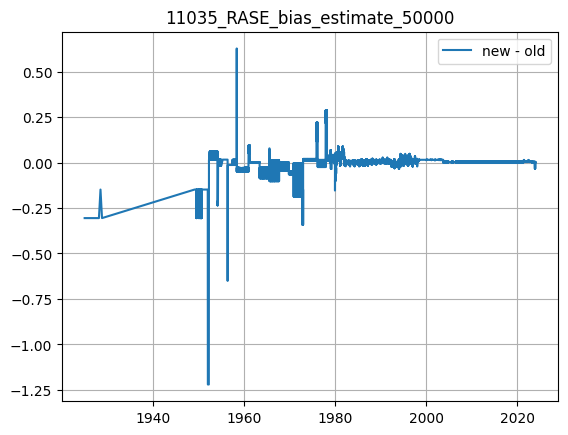

Mismatched Counts: {}


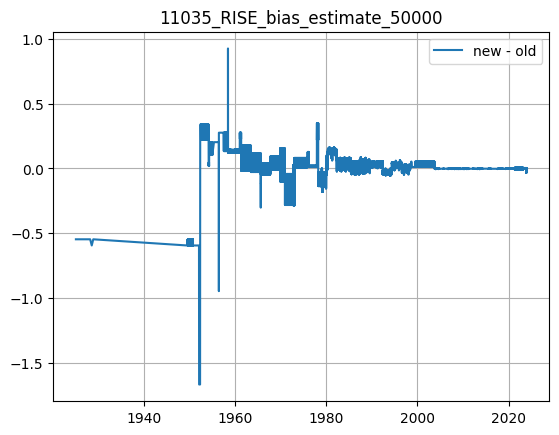

Mismatched Counts: {}


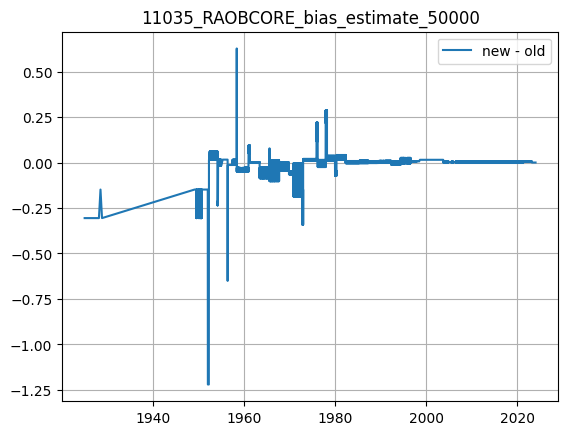

Mismatched Counts: {}


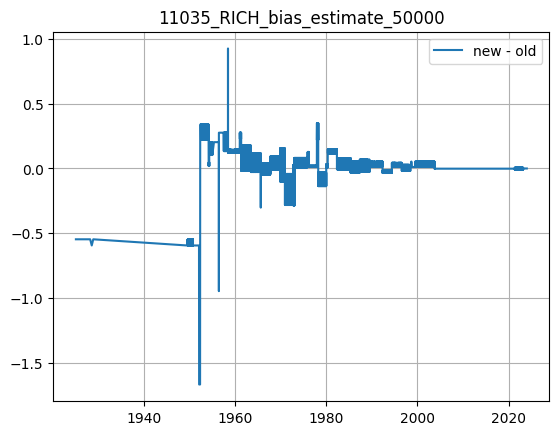

Mismatched Counts: {}


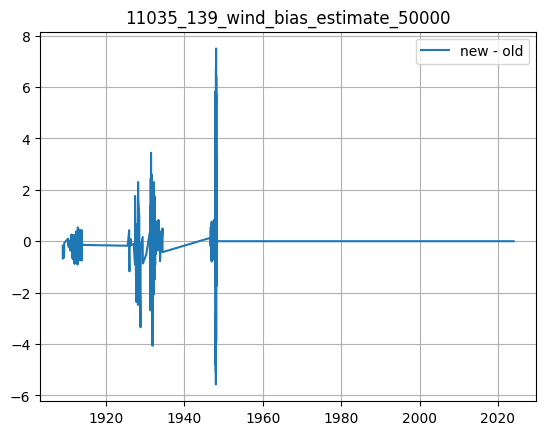

Mismatched Counts: {}


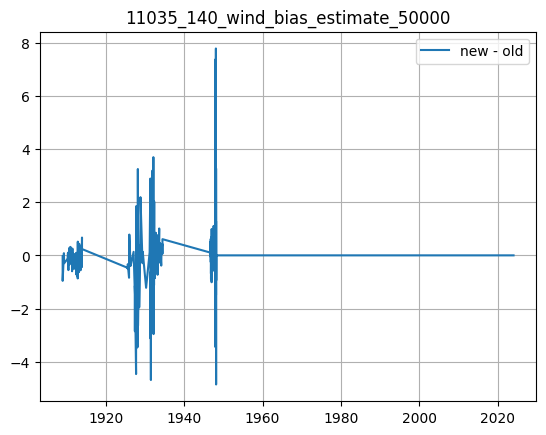

Mismatched Counts: {}


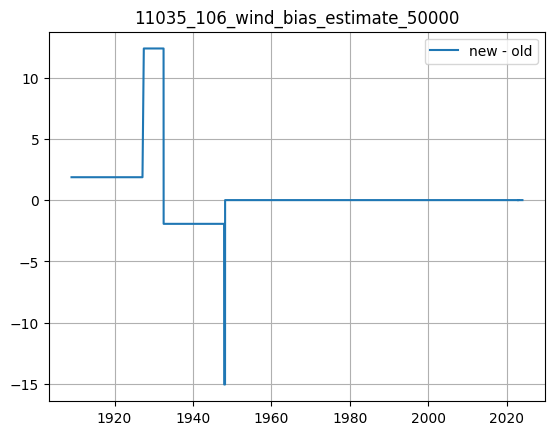

Mismatched Counts: {}


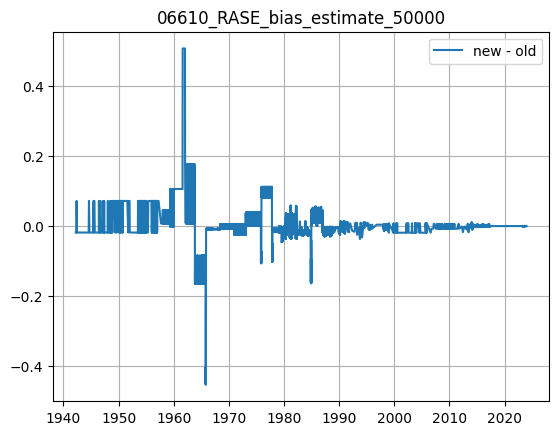

Mismatched Counts: {}


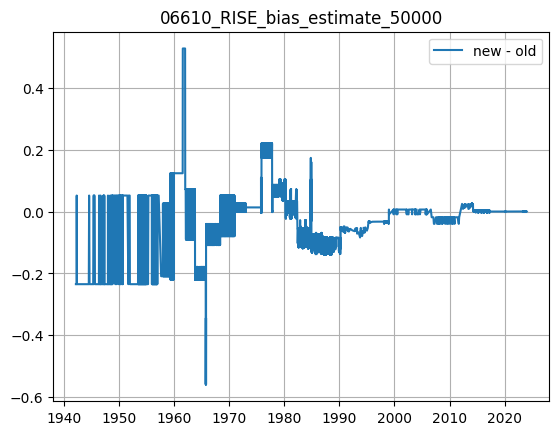

Mismatched Counts: {}


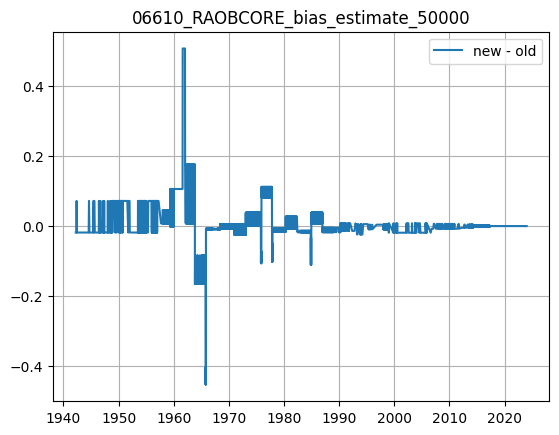

Mismatched Counts: {}


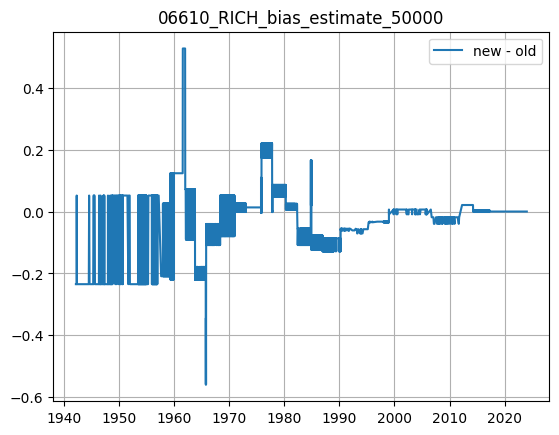

Mismatched Counts: {}


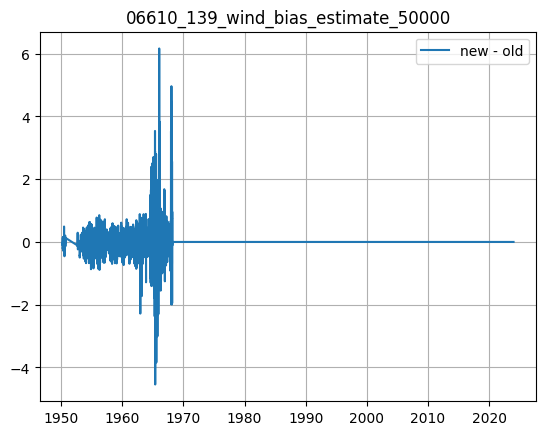

Mismatched Counts: {}


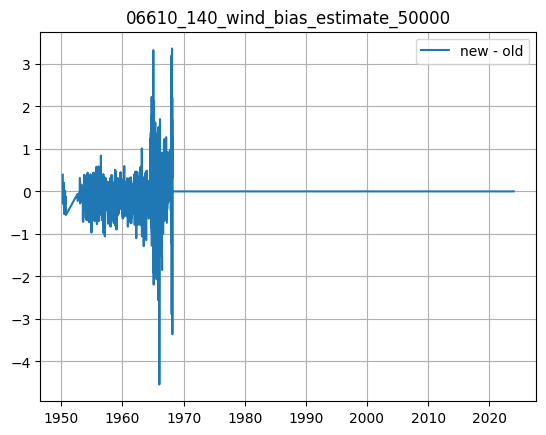

Mismatched Counts: {}


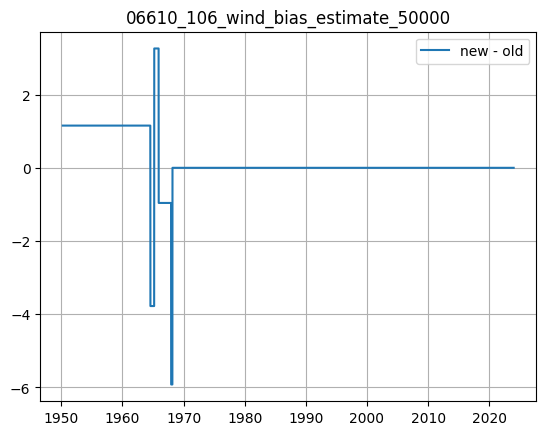

Mismatched Counts: {}


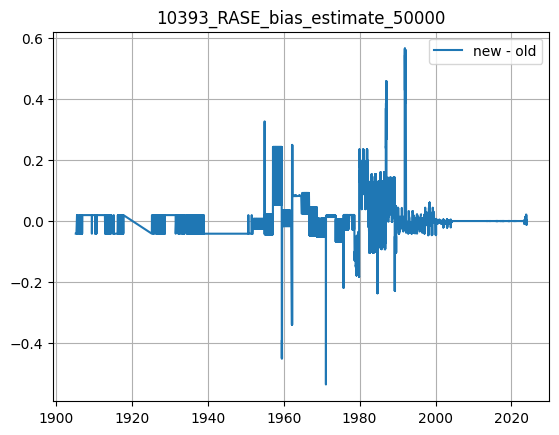

Mismatched Counts: {}


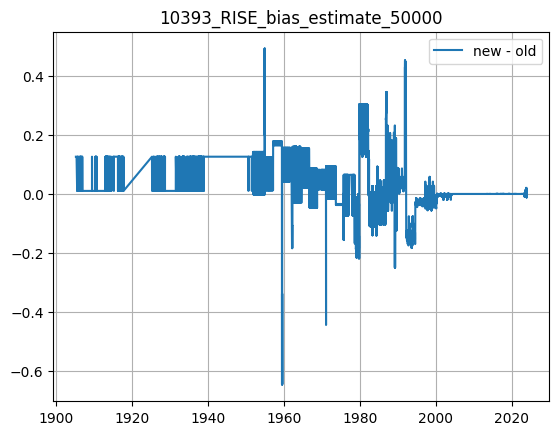

Mismatched Counts: {}


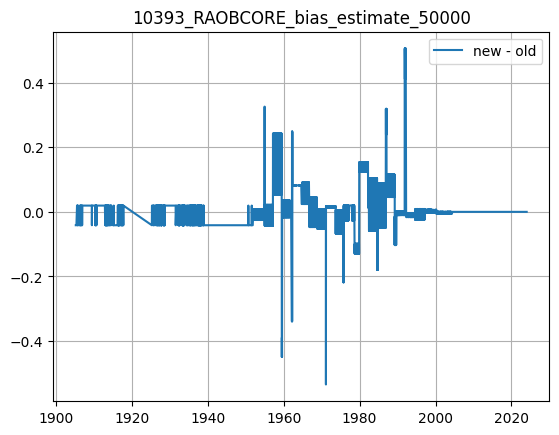

Mismatched Counts: {}


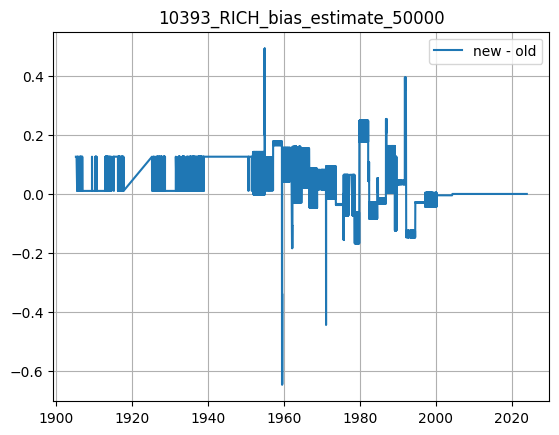

Mismatched Counts: {}


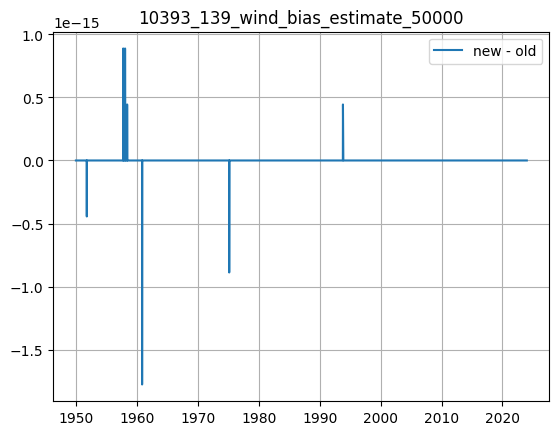

Mismatched Counts: {}


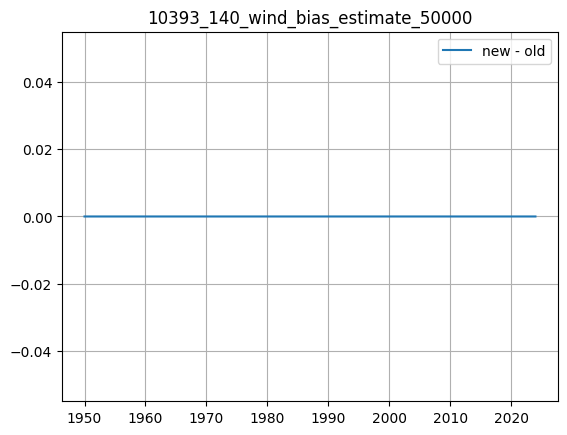

Mismatched Counts: {}


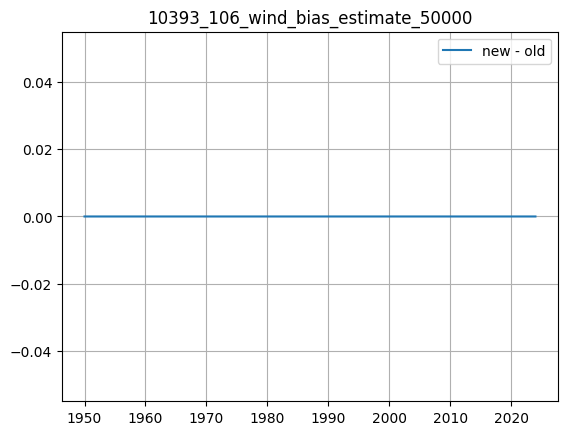

In [4]:
for i in ["11035", "06610", "10393"]:
    plot_diffs(i, 50000)

Mismatched Counts: {}


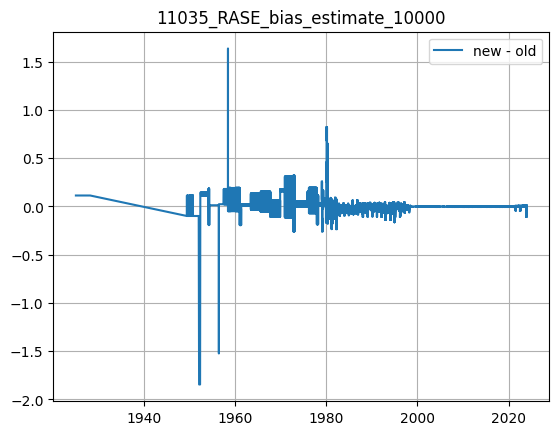

Mismatched Counts: {}


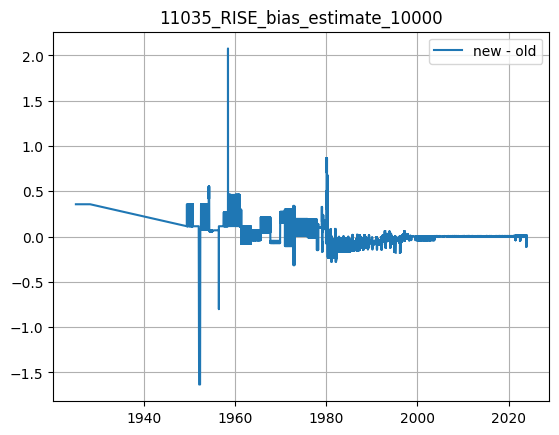

Mismatched Counts: {}


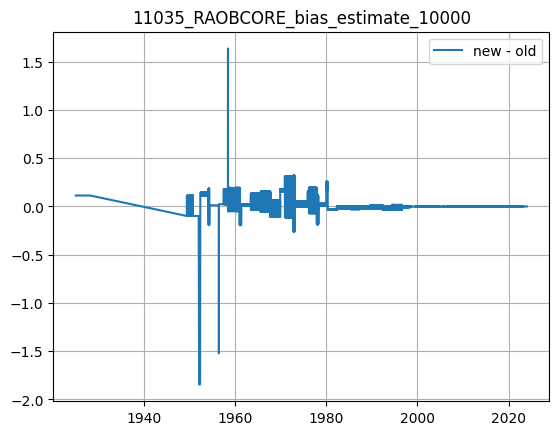

Mismatched Counts: {}


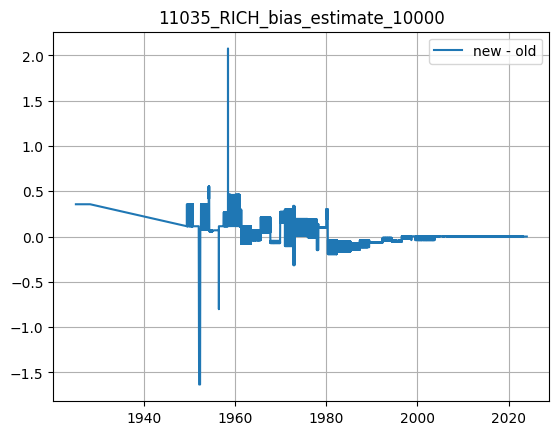

Mismatched Counts: {}


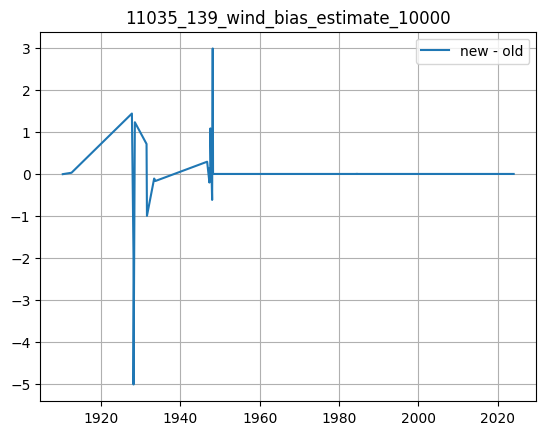

Mismatched Counts: {}


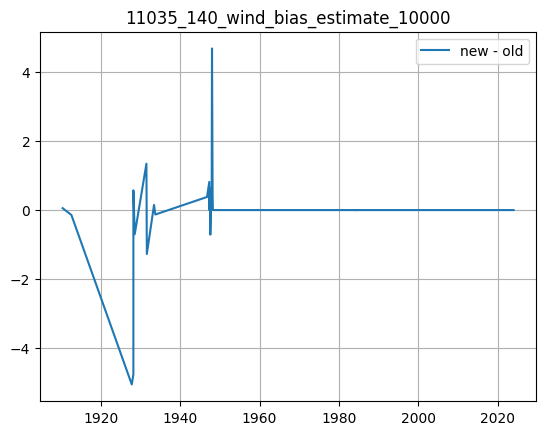

Mismatched Counts: {}


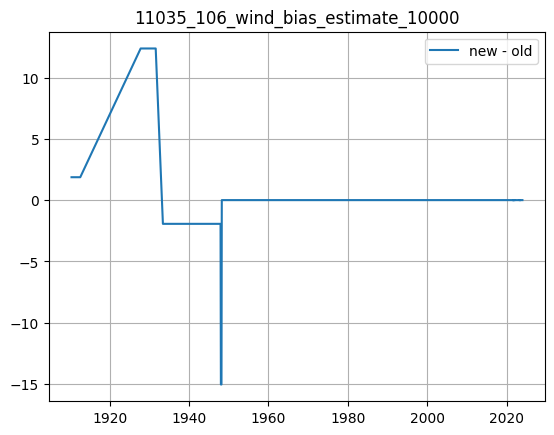

Mismatched Counts: {}


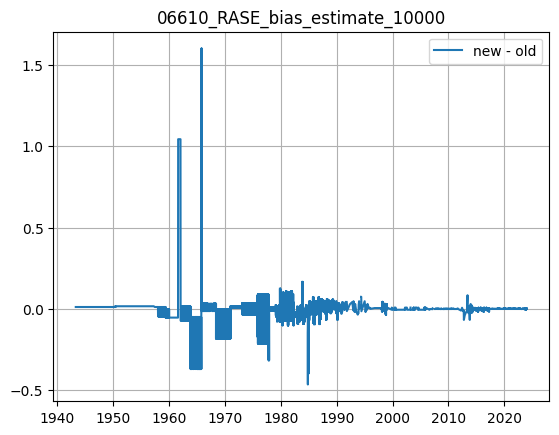

Mismatched Counts: {}


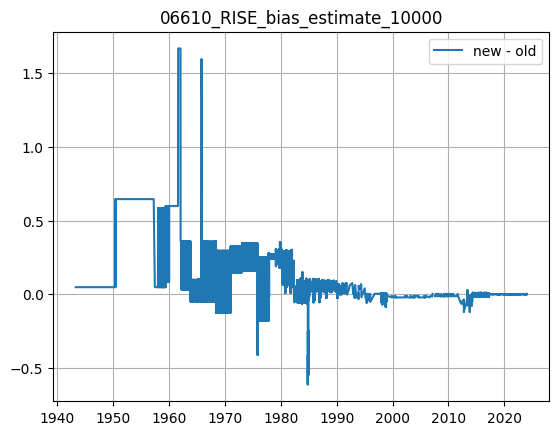

Mismatched Counts: {}


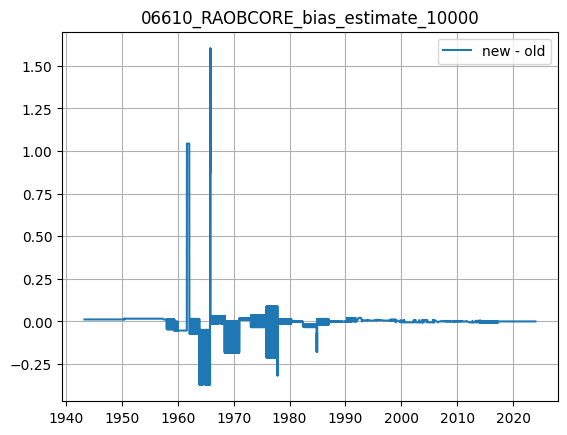

Mismatched Counts: {}


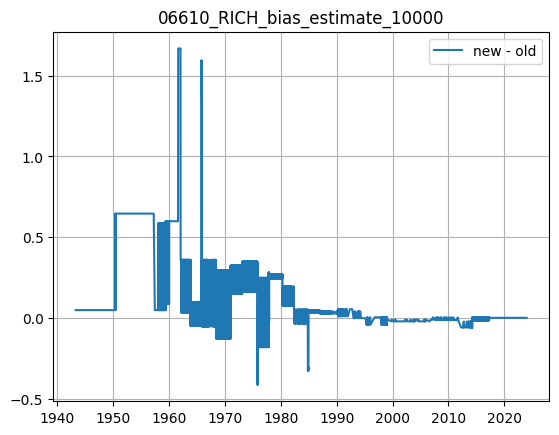

Mismatched Counts: {}


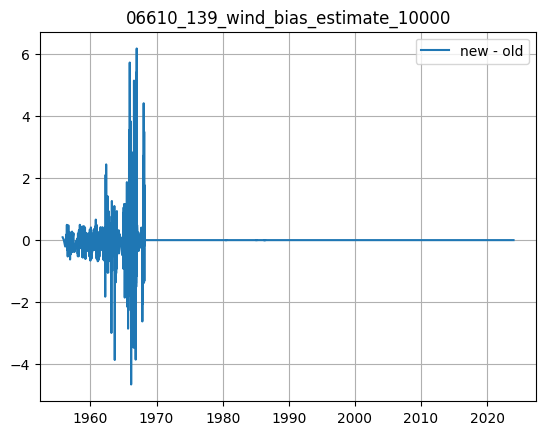

Mismatched Counts: {}


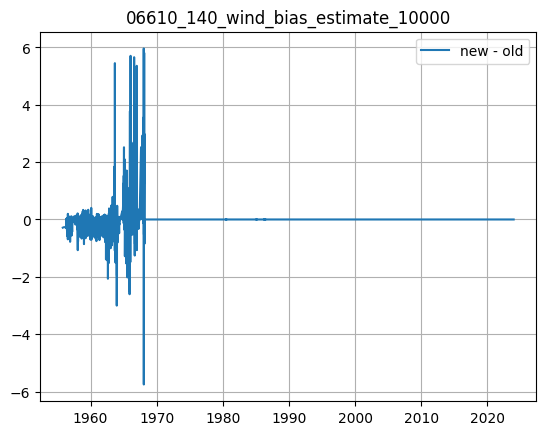

Mismatched Counts: {}


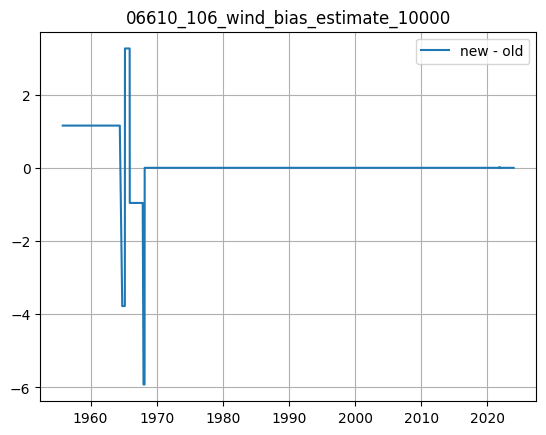

Mismatched Counts: {}


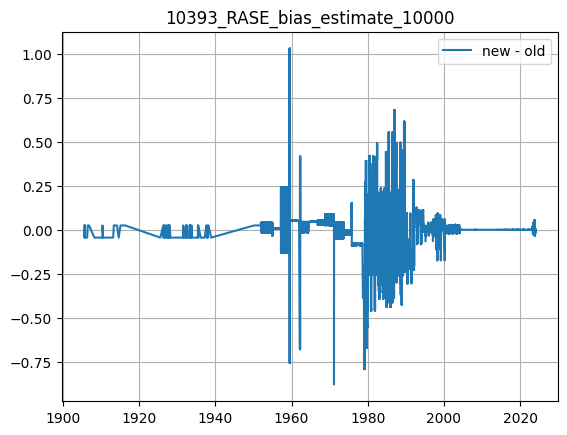

Mismatched Counts: {}


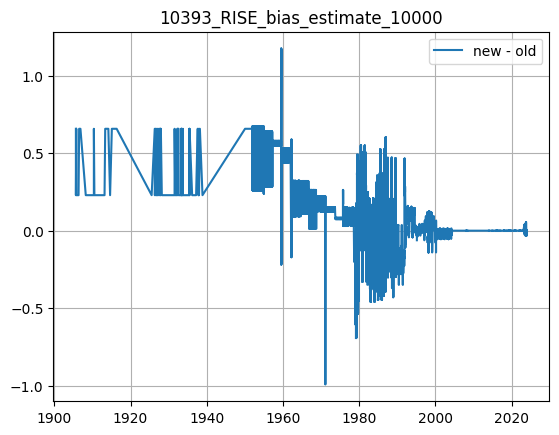

Mismatched Counts: {}


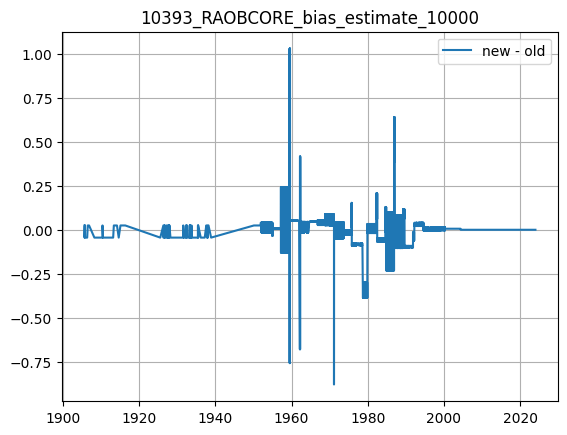

Mismatched Counts: {}


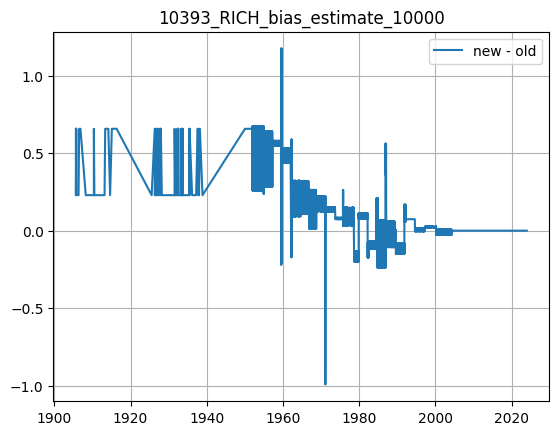

Mismatched Counts: {}


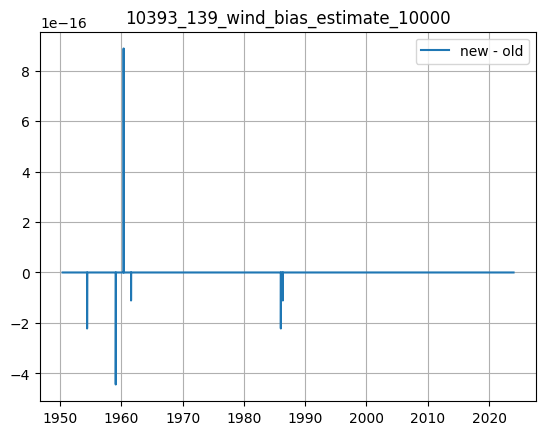

Mismatched Counts: {}


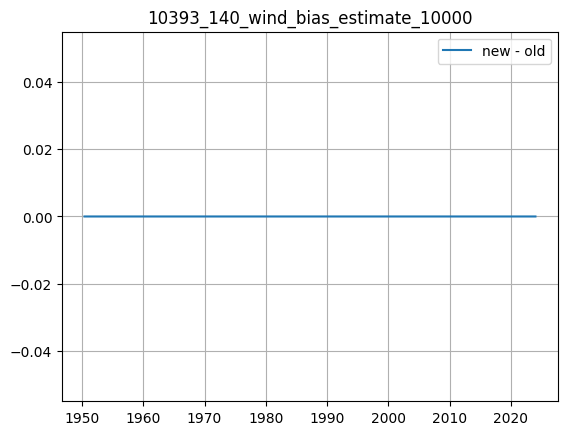

Mismatched Counts: {}


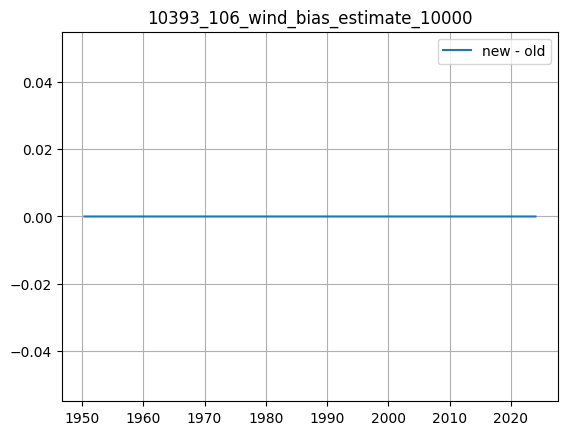

In [5]:
for i in ["11035", "06610", "10393"]:
    plot_diffs(i, 10000)

In [6]:
ts = 2871671400
dir_24 = "/mnt/users/scratch/leo/scratch/converted_v25/long/"
with h5py.File(glob.glob(dir_24 + "*10393*.nc")[0], "r") as file:
    idx = file['recordindices']['126'][:-1]
    rts = file['recordindices']['recordtimestamp'][:]
    new_idx = idx[rts == ts]
    print(file['observations_table']['observation_value'][new_idx])
    print(file['observations_table']['date_time'][new_idx])
    print(file['observations_table']['z_coordinate'][new_idx])


[218.9]
[2871671400]
[2100.]


In [7]:
# rts, idx[rts == ts]
len(rts), len(idx)

(119132, 119132)

In [8]:
with h5py.File('/mnt/users/scratch/leo/scratch/UH/CUON_HARVEST4/harvest_regular/era5_1759/0-20000-0-37717/0-20000-0-37717_1978_era5_1759_harvested_era5.1759.conv._1:37709.gz.nc', 'r') as fl:
    print(fl['observations_table']['z_coordinate_type'][:])
    print(fl['observations_table']['z_coordinate'][:])
    print(fl['observations_table']['observation_value'][:])
    print(fl['observations_table']['observed_variable'][:])


[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[ 30000.  40000.  40000.  40000.  40000.  40000.  50000.  50000.  50000.
  50000.  50000.  70000.  70000.  70000.  70000.  70000.  85000.  85000.
  85000.  85000.  85000.  88800.  88800.  88800.  88800. 100000.  24300.
  24300.  40000.  40000.  83600.  83600.  85000.  88400.  88400. 999990.
 999990.]
[9.1496047e+04 7.1980812e+04 2.5505000e+02 8.7159997e-01 2.6500000e+02
 2.1590000e+01 5.5897906e+04 2.5625000e+02 9.0319997e-01 2.5000000e+02
 1.7480000e+01 2.9419949e+04 2.7335001e+02 8.7650001e-01 3.2500000e+02
 0.0000000e+00 1.4729588e+04 2.6604999e+02 8.4219998e-01 3.5000000e+01
 3.0799999e+00 2.8375000e+02 7.5209999e-01 0.0000000e+00 0.0000000e+00
 1.5004175e+03 2.5505000e+02 4.9259999e-01 2.6145001e+02 3.2929999e-01
 3.0075000e+02 4.5010000e-01 2.9964999e+02 2.9714999e+02 6.0939997e-01
 2.4364999e+02 3.6899999e-01]
[117 117 126 138 106 107 117 126 138 106 107 117 126 138 106 107 117 126
 138 106 107 126 138 1

In [9]:
with h5py.File('/mnt/users/scratch/leo/scratch/UH/CUON_HARVEST4/harvest_regular/era5_2/0-20000-0-43599/0-20000-0-43599_1976_era5_2_harvested_era5.conv._1:41350.gz.nc', 'r') as fl:
    print(fl['observations_table']['z_coordinate_type'][:])
    print(fl['observations_table']['z_coordinate'][:])

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[39514.96484375 39514.96484375 39514.96484375 39514.96484375
 48247.41015625 48247.41015625 48247.41015625 48247.41015625
 50000.         50000.         50000.         50000.
 70000.         70000.         70000.         70000.
 85000.         85000.         85000.         85000.
 44638.01953125 44638.01953125 44638.01953125 44638.01953125
 50000.         50000.         50000.         50000.
 60796.94921875 60796.94921875 60796.94921875 60796.94921875
 70000.         70000.         70000.         70000.
 78775.5        78775.5        78775.5        78775.

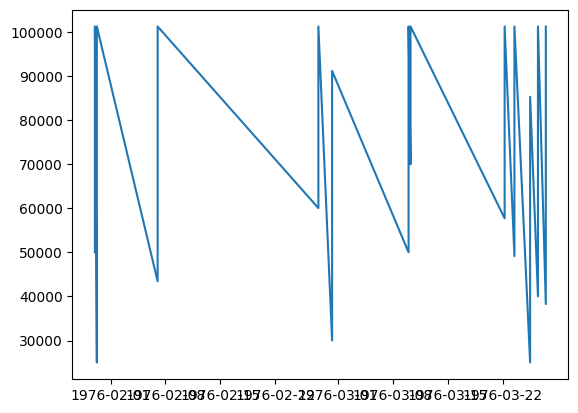

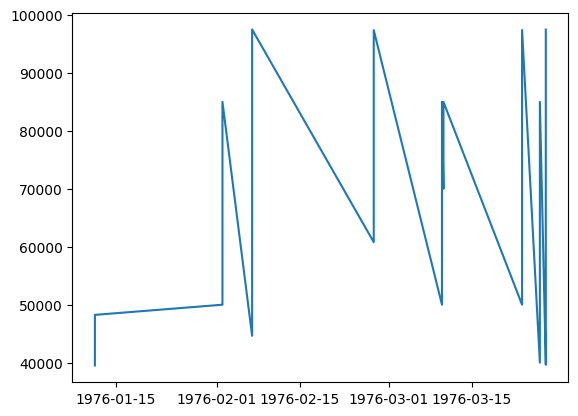

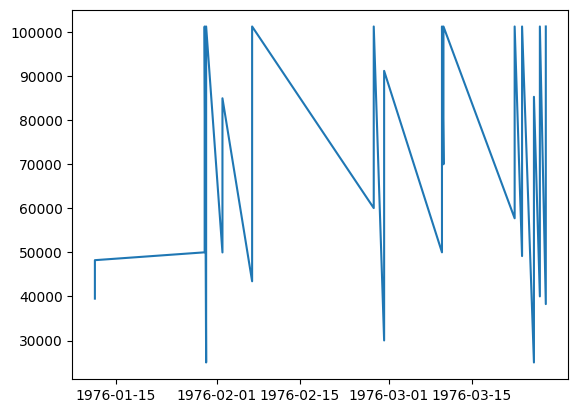

In [10]:
with h5py.File('/mnt/users/scratch/leo/scratch/UH/CUON_HARVEST4/harvest_regular/era5_2/0-20000-0-43599/0-20000-0-43599_1976_era5_2_harvested_era5.conv._41350.gz.nc', 'r') as fl:
    # print(fl['observations_table']['z_coordinate_type'][:])
    # print(fl['observations_table']['z_coordinate'][:])
    mpl.plot(seconds_to_datetime(fl['observations_table']['date_time'][:]), fl['observations_table']['z_coordinate'][:])
    mpl.show()
    mpl.close()

with h5py.File("/mnt/users/scratch/leo/scratch/UH/CUON_HARVEST4/harvest_regular/era5_2/0-20000-0-43599/0-20000-0-43599_1976_era5_2_harvested_era5.conv._1:41350.gz.nc", 'r') as fl:
    # print(fl['observations_table']['z_coordinate_type'][:])
    # print(fl['observations_table']['z_coordinate'][:])
    mpl.plot(seconds_to_datetime(fl['observations_table']['date_time'][:]), fl['observations_table']['z_coordinate'][:])
    mpl.show()
    mpl.close()



with h5py.File('/mnt/users/scratch/leo/scratch/UH/MERGED_YEARLY_20NOV2024_REGULAR/0-20000-0-43599/0-20000-0-43599_1976_CEUAS_merged_v3.nc') as fl:
    mpl.plot(seconds_to_datetime(fl['observations_table']['date_time'][:]), fl['observations_table']['z_coordinate'][:])
    mpl.show()
    mpl.close()

In [11]:
with h5py.File('/mnt/users/scratch/leo/scratch/UH/CUON_HARVEST4/harvest_regular/era5_2/0-20000-0-35188/0-20000-0-35188_1976_era5_2_harvested_era5.conv._1:35188.gz.nc', 'r') as fl:
    print(fl['observations_table']['z_coordinate_type'][:])
    print(fl['observations_table']['z_coordinate'][:])

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[ 85000. 100000. 100000. 100000. 100200. 100200. 100200. 100200. 100200.
 100200.  22800.  22800.  22800.  22800.  22800.  22800.  25000.  30000.
  30000.  30000.  40000.  40000.  40000.  40000.  40000.  40000.  40000.
  50000.  50000.  50000.  50000.  50000.  50000.  50000.  70000.  70000.
  70000.  70000.  70000.  70000.  70000.  85000.  85000.  85000.  85000.
  85000.  85000.  85000. 100000. 100000. 100000. 101100. 101100. 101100.
 101100. 101100. 101100.  27700.  27700.  63200.  76500.  76500.  78000.
  79600.  79600. 101600. 101600. 999990. 999990.  85100.  99200.  99200.
 101100. 101100. 999990. 999990.  97600.  97600. 101700. 101700. 103900.
 103900.  12400.  12400.  12400.  12400.  21500.  21500.  21